<a href="https://colab.research.google.com/github/stefanciprian/rd/blob/main/prices_and_volumes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

Load data from CSV, but first you need to uload the CSV file in the File System in Google Collab.

In [ ]:
import pandas as pd

data = pd.read_csv('LUMN.csv')
data.head(10)
data.sort_index(ascending=False)

,Date,Open,High,Low,Close,Adj Close,Volume
252,2024-08-01,3.27,4.20,3.26,4.1306,4.1306,52773643
251,2024-07-31,2.59,3.15,2.36,3.1500,3.1500,75766000
250,2024-07-30,2.02,3.44,1.94,2.6700,2.6700,161091500
249,2024-07-29,1.80,1.99,1.75,1.9400,1.9400,31081100
248,2024-07-26,1.69,1.77,1.68,1.7700,1.7700,18386700
...,...,...,...,...,...,...,...
4,2023-08-07,1.71,1.75,1.64,1.7400,1.7400,30195600
3,2023-08-04,1.67,1.77,1.64,1.6600,1.6600,34052900
2,2023-08-03,1.76,1.78,1.68,1.6800,1.6800,19715300
1,2023-08-02,1.75,1.87,1.68,1.7900,1.7900,39992700


Get data from Yahoo

In [ ]:
!pip install yfinance==0.2.12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.44
    Uninstalling yfinance-0.2.44:
      Successfully uninstalled yfinance-0.2.44


In [1]:
import yfinance as yf

data = []
ticker = "MNTS" # Example ticker for Microsoft
start_date = "2024-01-01"
end_date = "2024-11-05"  # Or today's date

try:
    data = yf.download(ticker, start=start_date, end=end_date)

    # Reset the column names to avoid multi-index
    # data.columns.name = None

    if data.empty:
        print(f"No data found for {ticker} within the specified date range.")
    else:
        # Reset the index to remove the multi-index
        data = data.reset_index()

        # Rename columns to match CSV-like format
        data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        data.sort_index(ascending=False)

        display(data)  # Display the formatted data
except Exception as e:
    print(f"An error occurred: {e}")

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-01-02 00:00:00+00:00,1.710,1.710,1.780,1.660,1.750,305700
1,2024-01-03 00:00:00+00:00,1.500,1.500,1.700,1.400,1.680,810000
2,2024-01-04 00:00:00+00:00,1.430,1.430,1.590,1.310,1.550,821800
3,2024-01-05 00:00:00+00:00,1.420,1.420,1.540,1.410,1.440,261200
4,2024-01-08 00:00:00+00:00,1.380,1.380,1.470,1.330,1.440,557600
...,...,...,...,...,...,...,...
208,2024-10-29 00:00:00+00:00,0.556,0.556,0.600,0.470,0.473,3404500
209,2024-10-30 00:00:00+00:00,0.520,0.520,0.551,0.510,0.540,1018100
210,2024-10-31 00:00:00+00:00,0.520,0.520,0.537,0.490,0.530,662500
211,2024-11-01 00:00:00+00:00,0.567,0.567,0.594,0.500,0.503,1676000


Scrape Yahoo site

In [ ]:
pip install requests beautifulsoup4

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
import json

def get_stock_volumes_yahoo(ticker: str) -> dict:
    # Construct the URL
    url = f"https://finance.yahoo.com/quote/{ticker}/history/"
    print(url)

    # Add a delay to mimic human browsing behavior
    time.sleep(2)  # Adds a 2-second delay

    # Create a request with a user-agent header
    headers = {
        "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                       "(KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36")
    }
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}")

    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Select the table elements containing stock volumes
    stock_volumes = []
    table = soup.find('table')  # Modify this selector as per your requirement

    if table:
        for row in table.find_all('tr'):
            columns = row.find_all('td')
            print(columns)
            if len(columns) > 1:  # Ensuring we have more than one column
                volume = columns[6].get_text()  # Assuming the 7th column contains the volume
                stock_volumes.append(volume)

    # Return the stock volumes as a JSON response
    return json.dumps({"volumes": stock_volumes}, indent=4)

# Example usage
ticker = "AAPL"
try:
    result = get_stock_volumes_yahoo(ticker)
    print(result)
except Exception as e:
    print(f"Error: {e}")


https://finance.yahoo.com/quote/AAPL/history/
[]
[<td class="yf-ewueuo">Oct 21, 2024</td>, <td class="yf-ewueuo">234.45</td>, <td class="yf-ewueuo">236.85</td>, <td class="yf-ewueuo">234.45</td>, <td class="yf-ewueuo">236.60</td>, <td class="yf-ewueuo">236.60</td>, <td class="yf-ewueuo">20,917,694</td>]
[<td class="yf-ewueuo">Oct 18, 2024</td>, <td class="yf-ewueuo">236.18</td>, <td class="yf-ewueuo">236.18</td>, <td class="yf-ewueuo">234.01</td>, <td class="yf-ewueuo">235.00</td>, <td class="yf-ewueuo">235.00</td>, <td class="yf-ewueuo">46,416,300</td>]
[<td class="yf-ewueuo">Oct 17, 2024</td>, <td class="yf-ewueuo">233.43</td>, <td class="yf-ewueuo">233.85</td>, <td class="yf-ewueuo">230.52</td>, <td class="yf-ewueuo">232.15</td>, <td class="yf-ewueuo">232.15</td>, <td class="yf-ewueuo">32,993,800</td>]
[<td class="yf-ewueuo">Oct 16, 2024</td>, <td class="yf-ewueuo">231.60</td>, <td class="yf-ewueuo">232.12</td>, <td class="yf-ewueuo">229.84</td>, <td class="yf-ewueuo">231.78</td>, <

# ARIMA

We calculate the ARIMA for the Volumes

In [ ]:
!pip install statsmodels==0.13.5

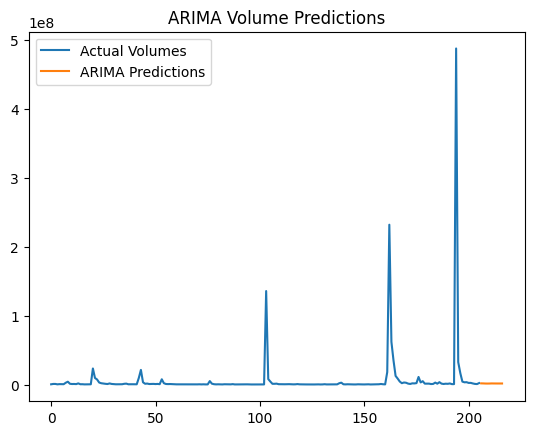

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Copy data
df = data

volumes = df['Volume']

model = ARIMA(volumes, order=(5, 1, 0))
model_fit = model.fit()

predictions = model_fit.predict(start=len(volumes), end=len(volumes) + 10)
# Predicts for the next 10 periods

plt.plot(volumes, label='Actual Volumes')
plt.plot(predictions, label='ARIMA Predictions')
plt.legend()
plt.title('ARIMA Volume Predictions')
plt.show()

# Bayesian



In [ ]:
import numpy as np

# Copy data
df = data

# Define a class to hold our prior belief
class Prior:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance

# Define a class to hold our likelihood
class Likelihood:
    def __init__(self, mean, variance):
        self.mean = mean
        self.variance = variance

# Function to update our prior with new evidence
def bayesian_update(prior, likelihood):
    prior_variance_inv = 1.0 / prior.variance
    likelihood_variance_inv = 1.0 / likelihood.variance

    updated_variance = 1.0 / (prior_variance_inv + likelihood_variance_inv)
    updated_mean = updated_variance * (prior.mean * prior_variance_inv + likelihood.mean * likelihood_variance_inv)

    return Prior(mean=updated_mean, variance=updated_variance)

# Function to calculate mean and variance from records
def calculate_statistics(df, scale_factor=1):
    volumes = df['Volume'].astype(float) / scale_factor  # Scale the volumes
    mean = np.mean(volumes)
    variance = np.var(volumes)
    return mean, variance

# Function to apply Bayesian update using the DataFrame
def bayesian_with_volumes_df(df, scale_factor=1):
    try:
        # Sort DataFrame by index in descending order to get the most recent records at the top
        df = df.sort_index(ascending=False)

        # Calculate statistics for the prior using all records
        prior_mean, prior_variance = calculate_statistics(df, scale_factor)

        # Extract the most recent record as new evidence
        latest_record = df.iloc[0]  # Get the most recent row
        new_evidence_volume = float(latest_record['Volume']) / scale_factor  # Use iloc[0] for scalar value

        # For simplicity, use the prior variance as the variance for the new evidence
        new_evidence_variance = prior_variance

        # Define the prior and likelihood based on these values
        prior = Prior(mean=prior_mean, variance=prior_variance)
        likelihood = Likelihood(mean=new_evidence_volume, variance=new_evidence_variance)

        # Perform Bayesian update
        updated_prior = bayesian_update(prior, likelihood)

        # Ensure the values are float scalars when printing
        print(f"Updated Prior: mean = {updated_prior.mean:.2f}, variance = {updated_prior.variance:.2f}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage with scaling (e.g., volumes in millions)
bayesian_with_volumes_df(df, scale_factor=1_000_000)

def print_legend():
    print("----- Legend for Updated Bayesian Results -----")
    print("Updated Mean: This is the new expected average trading volume after the Bayesian update, adjusted by the scaling factor. A higher mean suggests a higher expected volume of trades.")
    print("Updated Variance: This represents the uncertainty or variability around the updated mean. A lower variance indicates more confidence in the updated average, while a higher variance suggests more fluctuation is possible.")
    print("-----------------------------------------------\n")

# Call the function to print the legend
print_legend()




Updated Prior: mean = 34.03, variance = 112.02
----- Legend for Updated Bayesian Results -----
Updated Mean: This is the new expected average trading volume after the Bayesian update, adjusted by the scaling factor. A higher mean suggests a higher expected volume of trades.
Updated Variance: This represents the uncertainty or variability around the updated mean. A lower variance indicates more confidence in the updated average, while a higher variance suggests more fluctuation is possible.
-----------------------------------------------



# Chua's Circuit - Chaotic Algorithm

Need to revise

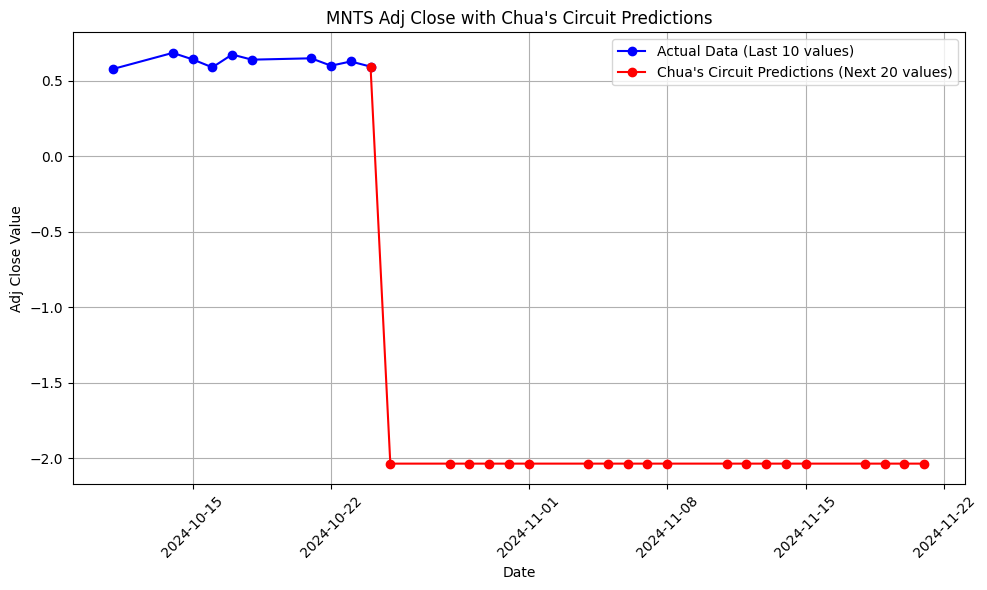

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# Copy data
df = data

# Chua's circuit parameters
alpha = 15
beta = 28
# Piecewise linear function for Chua's diode
def f(x):
    # Example piecewise linear function
    m1, m2 = -1, 1
    return m1 * x + (m2 - m1) * (x + 1) * (x > -1) * (x < 1)

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    initial_value = last_10_values[-1]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    initial_value = last_10_values[-1]

# Number of new values to predict with Chua's circuit
num_predictions = 20

# Time span for integration
t_span = (0, 100)
time_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time range for integration

# Define the Chua's circuit equations
def chua(t, state):
    x, y, z = state
    dxdt = alpha * (y - x - f(x))
    dydt = x - y + z
    dzdt = -beta * y
    return [dxdt, dydt, dzdt]

# Use solve_ivp to integrate Chua's circuit equations
initial_state = [initial_value, 0.0, 0.0]  # Assuming y and z start at 0
sol = solve_ivp(chua, t_span, initial_state, t_eval=time_eval)

# Extract the predicted values (using x values for demonstration)
predicted_values = sol.y[0][-num_predictions:]  # Take the last 20 predicted x values

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values.tolist()

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Chua's Circuit Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Chua's Circuit Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Duffing Oscillator - Chaotic Algorithm

Need to revise

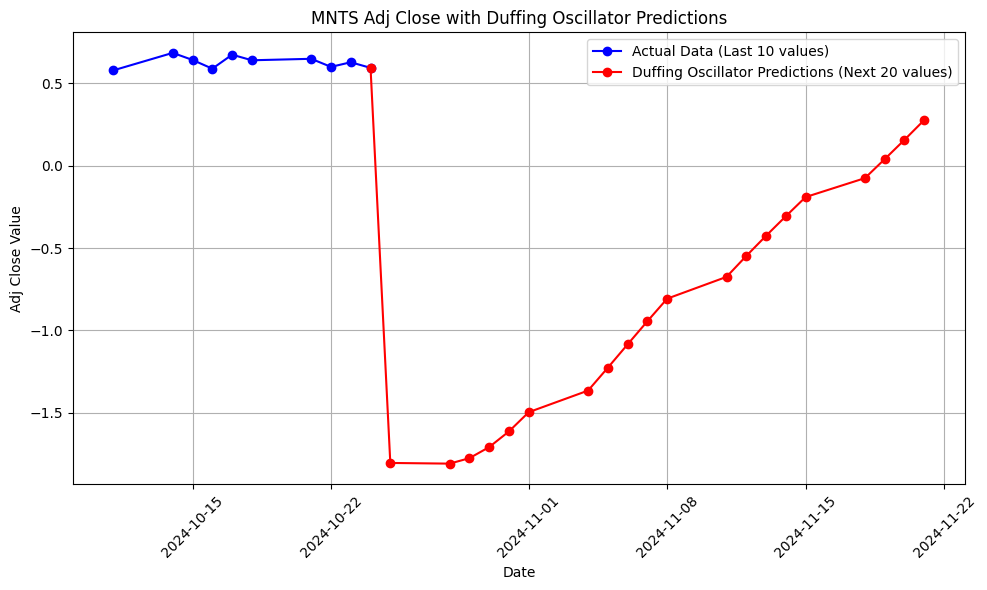

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# Copy data
df = data

# Duffing oscillator parameters
delta = 0.2    # Damping coefficient
alpha = -1.0   # Linear stiffness
beta = 1.0     # Nonlinear stiffness
gamma = 0.5    # Forcing amplitude
omega = 1.0    # Forcing frequency

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    initial_value = last_10_values[-1]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    initial_value = last_10_values[-1]

# Number of new values to predict with the Duffing oscillator
num_predictions = 20

# Time span for integration
t_span = (0, 100)
time_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time range for integration

# Define the Duffing oscillator equations
def duffing(t, state):
    x, v = state  # state = [displacement, velocity]
    dxdt = v
    dvdt = -delta * v - alpha * x - beta * x**3 + gamma * np.cos(omega * t)
    return [dxdt, dvdt]

# Use solve_ivp to integrate the Duffing oscillator equations
initial_state = [initial_value, 0.0]  # Assuming velocity starts at 0
sol = solve_ivp(duffing, t_span, initial_state, t_eval=time_eval)

# Extract the predicted values (using x values for demonstration)
predicted_values = sol.y[0][-num_predictions:]  # Take the last 20 predicted x values

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values.tolist()

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Duffing Oscillator Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Duffing Oscillator Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Fractional Gaussian Noise (fGn)

Simulated fGn: [-2.23865997e-02  1.11782456e+00  3.51797237e-01  4.60588876e-01
  5.88120997e-01 -8.02331979e-01  1.12721155e+00  7.09132687e-02
 -1.85580247e+00  6.22908463e-01 -1.93112639e+00  7.81279752e-03
  8.49989926e-01 -1.02172918e+00  2.79381138e-01 -8.04813672e-01
 -7.74958063e-01 -3.13053525e-01  5.96507917e-01  9.11001288e-01
  1.45164791e+00  3.21637704e-02 -5.35601045e-01 -2.94533943e-01
 -5.55170291e-01 -1.14972956e+00 -7.36090872e-01 -4.64721264e-01
  1.70267070e-01 -8.99741130e-01  7.74667171e-01  6.40925657e-01
  8.44290813e-02 -3.40435726e-01 -2.23616556e-01 -7.75729716e-01
 -5.05565063e-01 -8.87065211e-01  2.58895261e-01 -2.35464528e+00
 -1.20795150e+00  1.22988783e-01 -3.74581418e-01 -9.12138143e-01
 -1.72440459e+00  9.42232548e-02  1.00193418e+00  3.01861650e-01
 -1.17905445e+00  1.33696575e-01 -1.57511691e+00  8.65708494e-01
 -3.06769299e-01 -6.11568390e-01  9.49835120e-01  3.60389872e-01
 -6.76480984e-01 -2.65996691e-01  9.92472209e-02  3.67461655e-01
 -8.500459

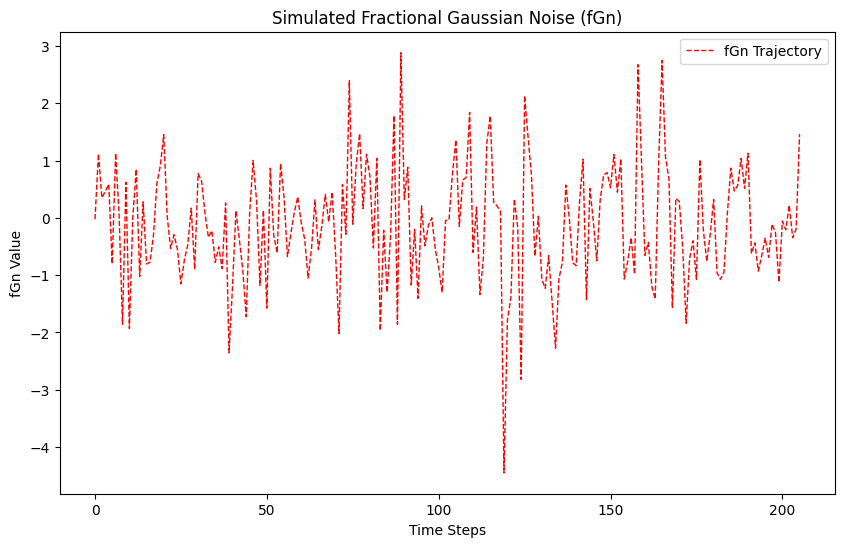

In [ ]:
import numpy as np
from scipy.linalg import cholesky

# Copy data
df = data

def generate_covariance_matrix(hurst, size):
    cov_matrix = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            cov_matrix[i, j] = 0.5 * ((i + 1) ** (2 * hurst) + (j + 1) ** (2 * hurst) - abs(i - j) ** (2 * hurst))

    return cov_matrix

def hurst_exponent(volumes):
    n = len(volumes)
    mean_vol = np.mean(volumes)

    rs = np.cumsum(volumes - mean_vol)
    range_rs = np.max(rs) - np.min(rs)
    stdev_vol = np.std(volumes)

    hurst_exp = np.log2(range_rs / stdev_vol) / np.log2(n)

    return hurst_exp

def simulate_fbm(hurst, length):
    cov_matrix = generate_covariance_matrix(hurst, length)
    cholesky_decomp = cholesky(cov_matrix, lower=True)
    z = np.random.normal(size=(length,))

    fbm_series = cholesky_decomp.dot(z)
    return fbm_series

def simulate_fgn(hurst, length):
    fbm_series = simulate_fbm(hurst, length + 1)
    fgn_series = np.diff(fbm_series)
    return fgn_series

# Calculate Hurst Exponent
hurst = hurst_exponent(np.array(df['Volume']))

# Simulate fGn
fgn_series = simulate_fgn(hurst, len(df['Volume']))
print(f"Simulated fGn: {fgn_series}")

plt.figure(figsize=(10, 6))

# Plot fGn
plt.plot(fgn_series, label='fGn Trajectory', color='r', linestyle='--', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('fGn Value')
plt.title('Simulated Fractional Gaussian Noise (fGn)')
plt.legend()
plt.show()


# Fractional Lévy Stable Motion (FLSM)

Simulated FLSM: [ 6.99939308e-01  1.70789011e+00  1.91504257e+00  6.86355225e+00
  6.43480586e+00  6.85693425e+00  4.86776927e+00  5.12683317e+00
  3.83855391e+00  5.91664189e+00  7.33600736e+00  6.61132051e+00
  5.20935907e+00  5.27723230e+00  4.57084229e+00  3.82135629e+00
  2.11207167e+00  2.76419083e+00  2.18727154e+00  1.72560732e+00
  1.10827294e+00  1.12939721e+00  4.11142398e+00  3.21859389e+00
  1.93127558e+00  2.14093009e+00  1.98690050e+00  3.73729171e+00
  3.92271850e+00  2.95475990e+00  1.25940479e+01  1.31922624e+01
  1.15617193e+01  1.14051790e+01  1.29874273e+01  1.33467437e+01
  1.37808011e+01  6.02515899e+00  1.18913731e+01  1.42722856e+01
  1.27140350e+01  1.09342277e+01  9.35267498e+00  9.09099463e+00
  7.54449388e+00  1.00946621e+01  8.57554956e+00  7.63186076e+00
  7.54207092e+00  7.18610998e+00  7.84321460e+00  1.66102861e+00
 -3.03207485e-01  3.84363337e+01  4.70383754e+01  4.52967128e+01
  4.17159822e+01  5.57636092e+01  5.72785948e+01  8.77676142e+01
  8.55666

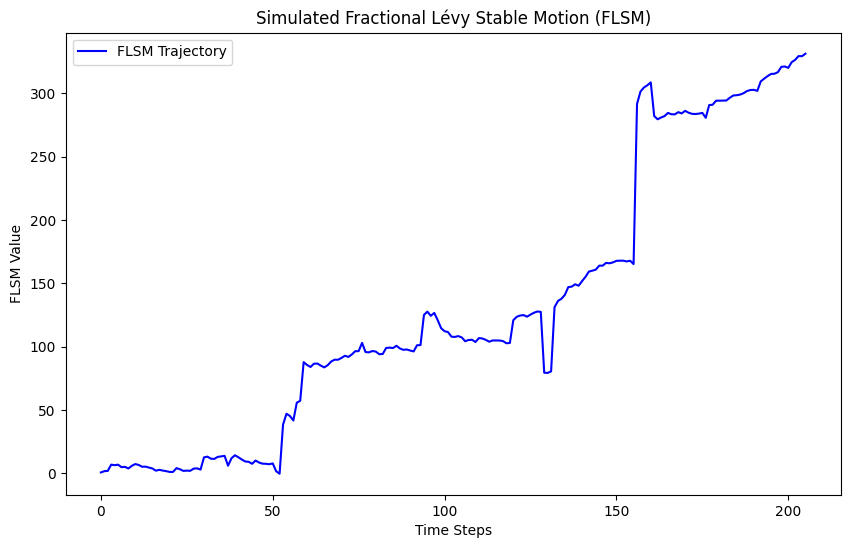

In [ ]:
import numpy as np
from scipy.linalg import cholesky

# Copy data
df = data

def generate_covariance_matrix(hurst, size):
    cov_matrix = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            cov_matrix[i, j] = 0.5 * ((i + 1) ** (2 * hurst) + (j + 1) ** (2 * hurst) - abs(i - j) ** (2 * hurst))

    return cov_matrix

def hurst_exponent(volumes):
    n = len(volumes)
    mean_vol = np.mean(volumes)

    rs = np.cumsum(volumes - mean_vol)
    range_rs = np.max(rs) - np.min(rs)
    stdev_vol = np.std(volumes)

    hurst_exp = np.log2(range_rs / stdev_vol) / np.log2(n)

    return hurst_exp

def levy_stable(alpha, beta, sigma, mu):
    u = np.random.uniform(-np.pi/2, np.pi/2)
    w = np.random.normal()

    if alpha == 1.0:
        return mu + beta * np.tan(np.pi / 2 + beta * u) * sigma * np.log(np.pi / 2 + beta * u)

    zeta = beta * np.tan(np.pi / 2 * alpha)
    term1 = (1 + zeta ** 2) ** 0.5
    term2 = np.tan(alpha * u)
    term3 = np.log(1 + zeta * term2)
    term4 = (1 / alpha) * (term1 * term2 - zeta * (w - term3))

    return mu + sigma * term4

def simulate_flm(hurst, length, alpha):
    cov_matrix = generate_covariance_matrix(hurst, length)
    cholesky_decomp = cholesky(cov_matrix, lower=True)

    z = [levy_stable(alpha, 0.0, 1.0, 0.0) for _ in range(length)]
    z_matrix = np.array(z)

    flm_series = cholesky_decomp.dot(z_matrix)
    return flm_series

# Calculate Hurst Exponent
hurst = hurst_exponent(np.array(df['Volume']))

# Simulate FLSM
flm_series = simulate_flm(hurst, len(df['Volume']), alpha=1.5)
print(f"Simulated FLSM: {flm_series}")

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(flm_series, label='FLSM Trajectory', color='b')

# Add labels and title
plt.xlabel('Time Steps')
plt.ylabel('FLSM Value')
plt.title('Simulated Fractional Lévy Stable Motion (FLSM)')
plt.legend()

# Display the plot
plt.show()

# Fuzzy Logic

In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.9 MB/s eta 0:00:00


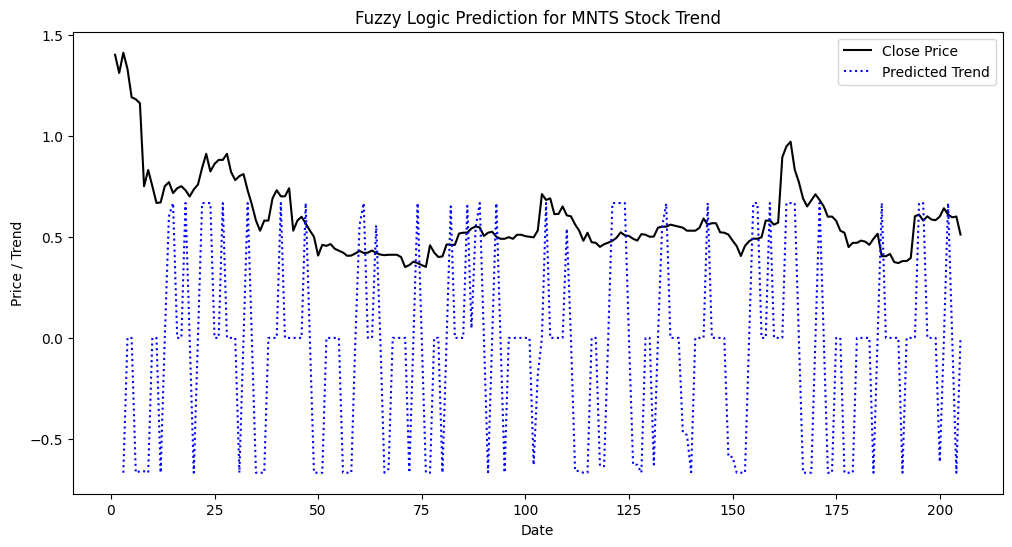

In [ ]:
import yfinance as yf
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pandas as pd
import matplotlib.pyplot as plt

# Copy data
df = data

df = df[['Date', 'Close']]
df = df.dropna()

# Calculate daily price change percentages
df['Change'] = df['Close'].pct_change() * 100
df = df.dropna()

# Fuzzy variables for the last two days' price changes
change_day1 = ctrl.Antecedent(np.arange(-5, 5, 0.1), 'change_day1')
change_day2 = ctrl.Antecedent(np.arange(-5, 5, 0.1), 'change_day2')
trend = ctrl.Consequent(np.arange(-1, 2, 1), 'trend')

# Define fuzzy membership functions for the inputs
change_day1['decrease'] = fuzz.trapmf(change_day1.universe, [-5, -5, -1, 0])
change_day1['stable'] = fuzz.trimf(change_day1.universe, [-1, 0, 1])
change_day1['increase'] = fuzz.trapmf(change_day1.universe, [0, 1, 5, 5])

change_day2['decrease'] = fuzz.trapmf(change_day2.universe, [-5, -5, -1, 0])
change_day2['stable'] = fuzz.trimf(change_day2.universe, [-1, 0, 1])
change_day2['increase'] = fuzz.trapmf(change_day2.universe, [0, 1, 5, 5])

# Define fuzzy membership functions for the output
trend['decrease'] = fuzz.trimf(trend.universe, [-1, -1, 0])
trend['stable'] = fuzz.trimf(trend.universe, [-1, 0, 1])
trend['increase'] = fuzz.trimf(trend.universe, [0, 1, 1])

rule1 = ctrl.Rule(change_day1['decrease'] & change_day2['decrease'], trend['decrease'])
rule2 = ctrl.Rule(change_day1['stable'] & change_day2['stable'], trend['stable'])
rule3 = ctrl.Rule(change_day1['increase'] & change_day2['increase'], trend['increase'])
rule4 = ctrl.Rule(change_day1['decrease'] & change_day2['increase'], trend['stable'])
rule5 = ctrl.Rule(change_day1['increase'] & change_day2['decrease'], trend['stable'])

# Create the control system and simulation
trend_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
trend_sim = ctrl.ControlSystemSimulation(trend_ctrl)

# Predict trends for the last few days
predictions = []
for i in range(2, len(df)):
    trend_sim.input['change_day1'] = df['Change'].iloc[i-1]
    trend_sim.input['change_day2'] = df['Change'].iloc[i-2]
    trend_sim.compute()
    predictions.append(trend_sim.output['trend'])

# Add predictions to the DataFrame
df['Predicted_Trend'] = [np.nan, np.nan] + predictions  # Align with input data

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label="Close Price", color="black")
plt.plot(df['Predicted_Trend'], label="Predicted Trend", color="blue", linestyle="dotted")
plt.xlabel("Date")
plt.ylabel("Price / Trend")
plt.title(f"Fuzzy Logic Prediction for {ticker} Stock Trend")
plt.legend()
plt.show()

# Heatmap

In [ ]:
!pip install matplotlib numpy

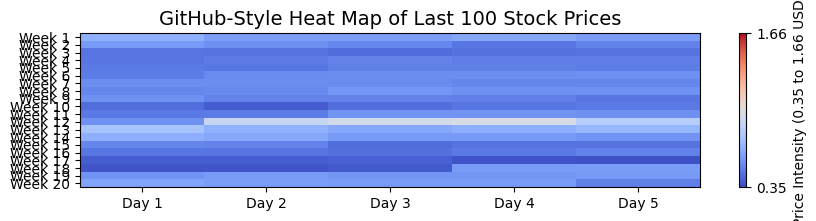

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Copy data
df = data

# Load the data (replace with your actual DataFrame or CSV file path)

# Extract the last 100 'Close' prices
last_100_close_prices = df['Close'].tail(100).tolist()

# Normalize the prices for the heatmap
min_val, max_val = df['Close'].min(), df['Close'].max()
normalized_prices = [(price - min_val) / (max_val - min_val) for price in last_100_close_prices]

# Reshape the data into a 20x5 grid
price_grid = np.array(normalized_prices).reshape(20, 5)

# Create the heatmap
plt.figure(figsize=(10, 2))
plt.imshow(price_grid, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)

# Add colorbar with the original price scale
cbar = plt.colorbar(label=f'Price Intensity ({min_val:.2f} to {max_val:.2f} USD)')
cbar.set_ticks([0, 1])
cbar.set_ticklabels([f'{min_val:.2f}', f'{max_val:.2f}'])

# Set labels
plt.title('GitHub-Style Heat Map of Last 100 Stock Prices', fontsize=14)
plt.xticks(range(5), labels=[f'Day {i+1}' for i in range(5)])
plt.yticks(range(20), labels=[f'Week {i+1}' for i in range(20)])

# Show the heatmap
plt.show()


# Hénon map - Chaotic Algorithm

Need to revise

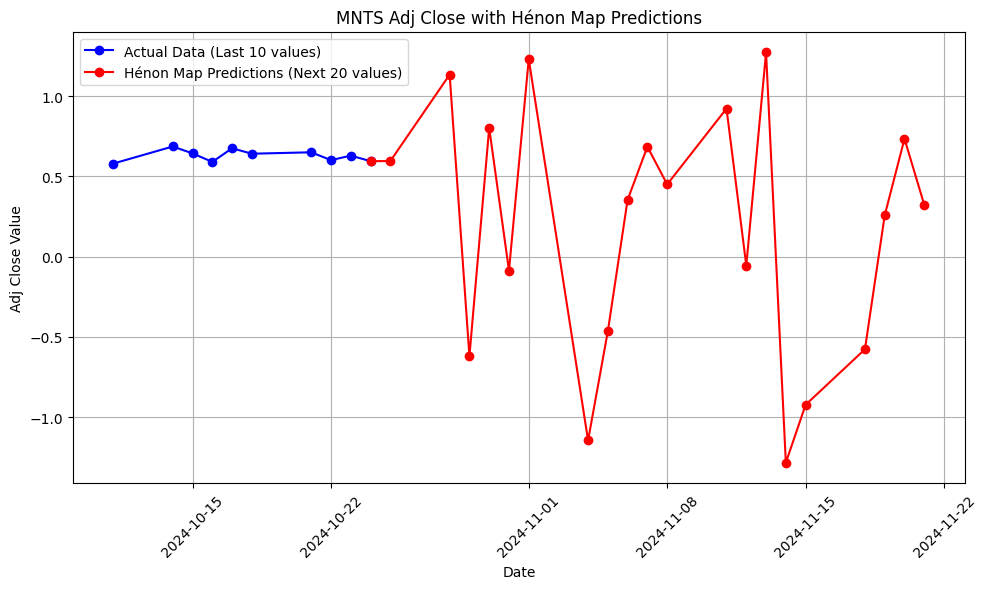

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Copy data
df = data

# Hénon map parameters
a = 1.4
b = 0.3
value_limit = 1e3  # Cap values at a reasonable limit to prevent overflow

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    x, y = last_10_values[-1], last_10_values[-2]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    x, y = last_10_values[-1], last_10_values[-2]

# Number of new values to predict with the Hénon map
num_predictions = 20

# Arrays to store new predicted values
predicted_values = [x]  # Start with the last known value

# Generate the next 20 points using the Hénon map
for _ in range(num_predictions - 1):
    # Calculate the next values
    x_next = 1 - a * x**2 + y
    y_next = b * x

    # Apply limit to prevent overflow
    if abs(x_next) > value_limit or abs(y_next) > value_limit:
        x_next, y_next = 1.0, 1.0  # Reset to avoid runaway values

    # Append the new prediction
    predicted_values.append(x_next)

    # Update x and y for the next iteration
    x, y = x_next, y_next

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Hénon Map Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Hénon Map Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Higuchi Fractal Dimension

In [ ]:
import numpy as np

# Copy data
df = data

def higuchi_fractal_dimension(time_series, kmax):
    n = len(time_series)
    lengths = np.zeros(kmax)

    for k in range(1, kmax + 1):
        lk = 0.0
        for m in range(k):
            lmk = 0.0
            for i in range(m, n - k, k):
                lmk += abs(time_series[i + k] - time_series[i])
            lmk /= (n - m) / k
            lk += lmk
        lengths[k - 1] = lk / k

    log_lk = np.log10(lengths)
    log_k = np.log10(np.arange(1, kmax + 1))

    # Linear regression to calculate the slope
    slope = np.polyfit(log_k, log_lk, 1)[0]

    return slope

# Normalize the volumes
max_volume = max(df['Volume'])
normalized_volumes = [v / max_volume for v in df['Volume']]

# Calculate Higuchi Fractal Dimension
fractal_dimension = higuchi_fractal_dimension(normalized_volumes, 10) # Need to think about kmax
print(f"Higuchi Fractal Dimension: {fractal_dimension}")
print('\nInterpretation of the Higuchi Fractal Dimension:')
print('1.0 ≤ HFD < 2.0: Indicates smoother or rougher data.')
print('HFD ≈ 1.5: Often observed in fractional Brownian motion.')
print('HFD > 2.0 or < 1.0: Unusual values.\n')

Higuchi Fractal Dimension: 0.07930563984346778

Interpretation of the Higuchi Fractal Dimension:
1.0 ≤ HFD < 2.0: Indicates smoother or rougher data.
HFD ≈ 1.5: Often observed in fractional Brownian motion.
HFD > 2.0 or < 1.0: Unusual values.



# Hurst Exponent

In [ ]:
import numpy as np

# Copy data
df = data

def hurst_exponent(volumes):
    n = len(volumes)
    mean_vol = np.mean(volumes)

    rs = np.cumsum(volumes - mean_vol)
    range_rs = np.max(rs) - np.min(rs)
    stdev_vol = np.std(volumes)

    hurst_exp = np.log2(range_rs / stdev_vol) / np.log2(n)

    return hurst_exp

# Calculate Hurst Exponent
hurst = hurst_exponent(np.array(df['Volume']))
print(f"Hurst Exponent: {hurst}")
# Print interpretation legend
print("\nInterpretation of the Hurst Exponent:")
print("H < 0.5: Suggests mean-reverting behavior.")
print("H = 0.5: Suggests a random walk.")
print("H > 0.5: Suggests trending behavior.\n")

Hurst Exponent: 0.6529419116306946

Interpretation of the Hurst Exponent:
H < 0.5: Suggests mean-reverting behavior.
H = 0.5: Suggests a random walk.
H > 0.5: Suggests trending behavior.



# Ikeda Map - Chaotic Algorithm

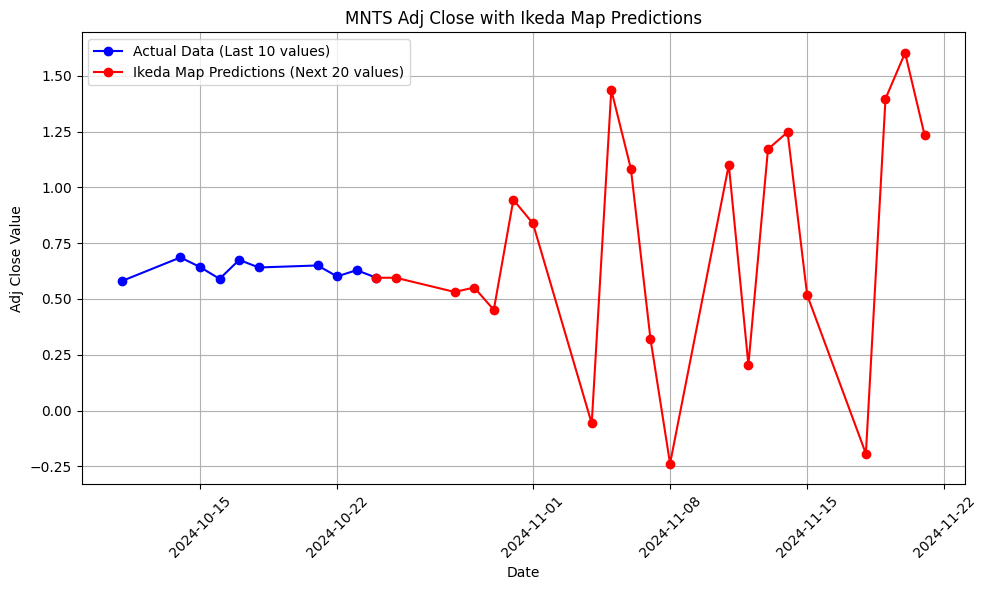

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Copy data
df = data

# Parameters for the Ikeda map
u = 0.9
kappa = 0.4
p = 6.0

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    x, y = last_10_values[-1], last_10_values[-2]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    x, y = last_10_values[-1], last_10_values[-2]

# Number of new values to predict with the Ikeda map
num_predictions = 20

# Arrays to store new predicted values
predicted_values = [x]  # Start with the last known value

# Generate the next 20 points using the Ikeda map
for _ in range(num_predictions - 1):
    theta = kappa - (p / (1 + x**2 + y**2))
    x_next = 1 + u * (x * np.cos(theta) - y * np.sin(theta))
    y_next = u * (x * np.sin(theta) + y * np.cos(theta))

    # Append the new prediction
    predicted_values.append(x_next)

    # Update x and y for the next iteration
    x, y = x_next, y_next

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Ikeda Map Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Ikeda Map Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Julia Sets - Chaotic Algorithm

Need to revise

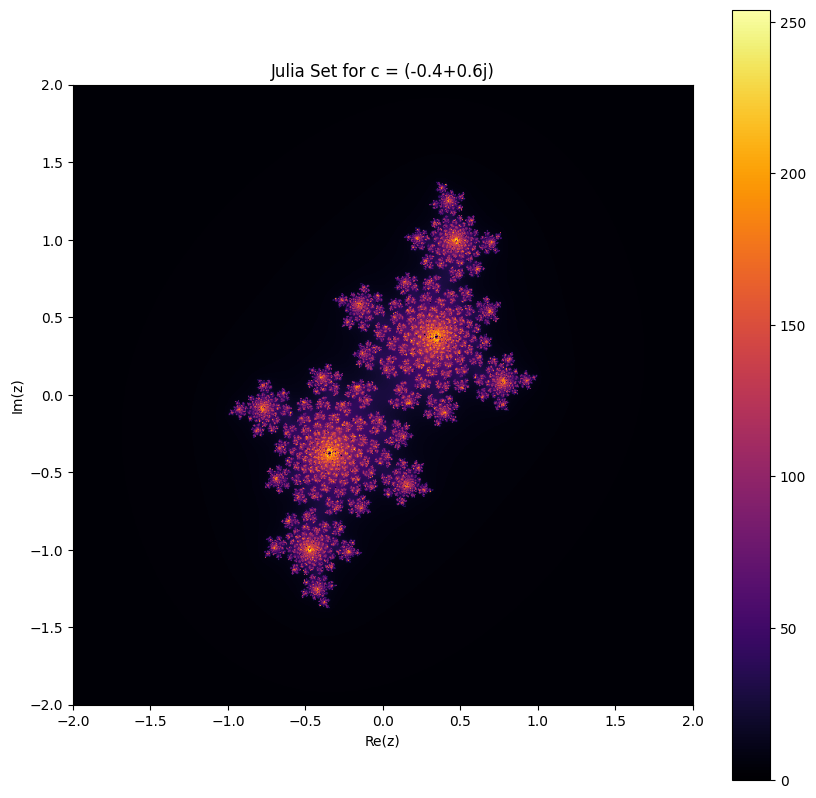

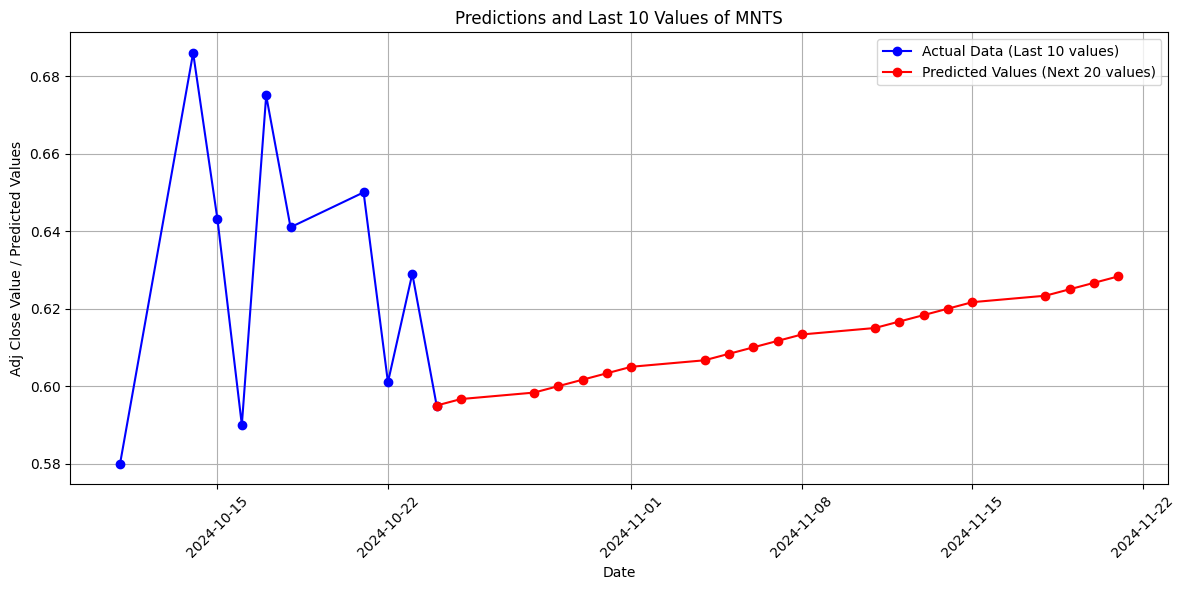

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Copy data
df = data

# Define the function to compute the Julia set
def julia_set(c, xlim, ylim, width, height, max_iter):
    # Create a grid of complex numbers
    x = np.linspace(xlim[0], xlim[1], width)
    y = np.linspace(ylim[0], ylim[1], height)
    z = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    z = z[:, 0] + 1j * z[:, 1]  # Create complex grid

    # Initialize array to hold the iteration counts
    img = np.zeros(z.shape, dtype=int)

    # Iterate over each point in the complex plane
    for i in range(max_iter):
        mask = np.abs(z) < 100  # Only iterate if z is within a certain bound
        img[mask] = i  # Assign the iteration count
        z[mask] = z[mask] ** 2 + c  # Update z

    img[img == max_iter - 1] = 0  # Mark points that never escaped

    # Reshape the result back to the image dimensions
    img = img.reshape((height, width))
    return img

# Parameters for the Julia set
c = complex(-0.4, 0.6)  # The complex parameter
xlim = (-2, 2)          # X-axis limits
ylim = (-2, 2)          # Y-axis limits
width, height = 800, 800  # Image size
max_iter = 256          # Maximum number of iterations

# Generate the Julia set
julia_image = julia_set(c, xlim, ylim, width, height, max_iter)

# Plotting the Julia set
plt.figure(figsize=(10, 10))
plt.imshow(julia_image, extent=(xlim[0], xlim[1], ylim[0], ylim[1]), cmap='inferno')
plt.colorbar()
plt.title(f"Julia Set for c = {c}")
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.grid(False)
plt.show()

# Chart

# Define the function to compute the Julia set
def julia_set2(c, xlim, ylim, width, height, max_iter):
    # Create a grid of complex numbers
    x = np.linspace(xlim[0], xlim[1], width)
    y = np.linspace(ylim[0], ylim[1], height)
    z = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    z = z[:, 0] + 1j * z[:, 1]  # Create complex grid

    # Initialize array to hold the iteration counts
    img = np.zeros(z.shape, dtype=int)

    # Iterate over each point in the complex plane
    for i in range(max_iter):
        mask = np.abs(z) < 100  # Only iterate if z is within a certain bound
        img[mask] = i  # Assign the iteration count
        z[mask] = z[mask] ** 2 + c  # Update z

    img[img == max_iter - 1] = 0  # Mark points that never escaped

    # Reshape the result back to the image dimensions
    img = img.reshape((height, width))
    return img

# Parameters for the Julia set
c = complex(-0.4, 0.6)  # The complex parameter
xlim = (-2, 2)          # X-axis limits
ylim = (-2, 2)          # Y-axis limits
width, height = 800, 800  # Image size
max_iter = 256          # Maximum number of iterations

# Generate the Julia set
julia_image = julia_set2(c, xlim, ylim, width, height, max_iter)

# Extract real values for time series predictions
real_values = np.linspace(xlim[0], xlim[1], width)[:max_iter]  # Use only a subset for simplicity

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data

# Number of new values to predict with the Julia set real values
num_predictions = 20

# Generate predictions based on a trend from last 10 values
# Calculate the mean and the trend (slope)
last_value = last_10_values[-1]
predicted_values = []

# Simple linear prediction based on last value
slope = (last_10_values[-1] - last_10_values[0]) / 9  # Slope of the line connecting first and last
for i in range(num_predictions):
    next_value = last_value + slope  # Predict next value based on slope
    predicted_values.append(next_value)
    last_value = next_value  # Update last value for next iteration

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(12, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Predicted Values (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value / Predicted Values")
plt.title(f"Predictions and Last 10 Values of {ticker}")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Kalman Filter - Linear Quadratic Estimation

https://en.wikipedia.org/wiki/Kalman_filter

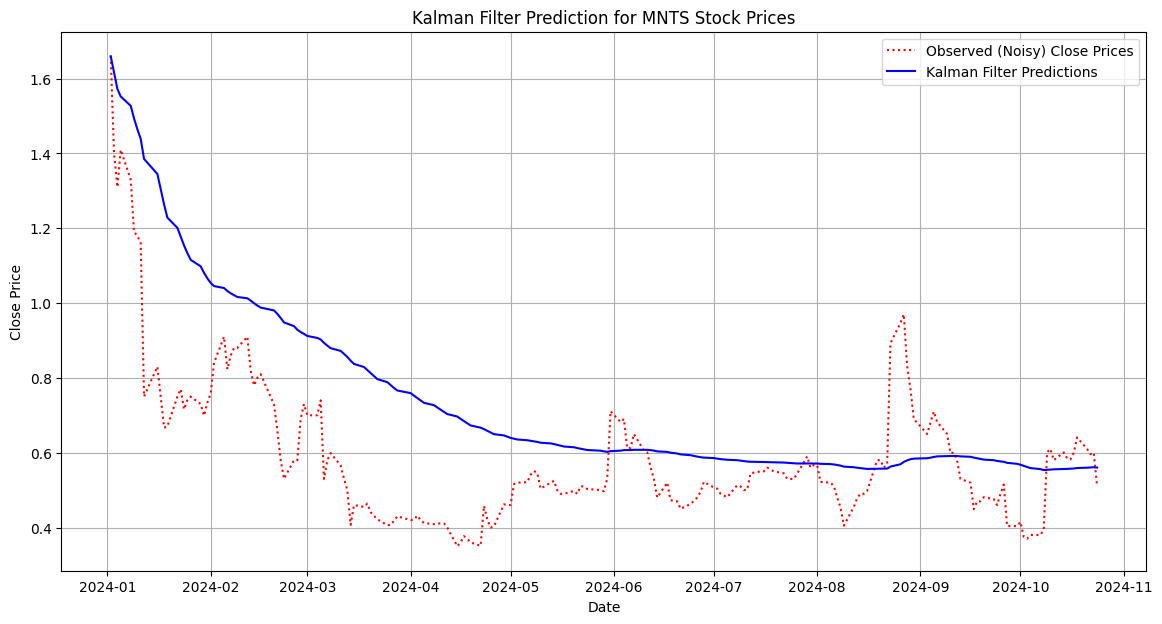

In [ ]:
# Copy data
df = data

df = df[['Date', 'Close']]
df = df.dropna()

# Kalman Filter parameters
observed_values = df['Close'].values  # Observed prices (time series)
predictions = []  # To store predictions
x = observed_values[0]  # Initial state estimate
P = 1  # Initial uncertainty

Q = 1e-3  # Process variance
R = 4     # Measurement variance

# Kalman Filter process
for z in observed_values:
    # Prediction step
    x = x  # No control input, so just state estimate
    P = P + Q  # Update uncertainty in the prediction

    # Update step
    K = P / (P + R)  # Kalman Gain
    x = x + K * (z - x)  # Update estimate with measurement
    P = (1 - K) * P  # Update uncertainty

    # Store prediction
    predictions.append(x)

# Add predictions to DataFrame
df['Kalman_Prediction'] = predictions

# Plot observed and predicted values
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label="Observed (Noisy) Close Prices", color="red", linestyle="dotted")
plt.plot(df['Date'], df['Kalman_Prediction'], label="Kalman Filter Predictions", color="blue")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title(f"Kalman Filter Prediction for {ticker} Stock Prices")
plt.legend()
plt.grid(True)
plt.show()

# Linear Regression

Need to revise

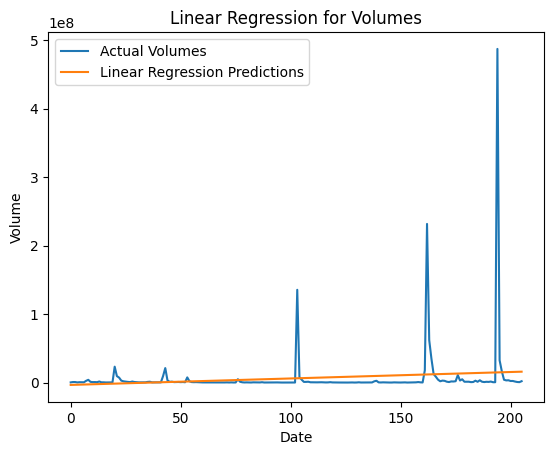

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Copy data
df = data

# Assuming your DataFrame is named 'df' and the volume column is 'Volume'
X = np.arange(len(df)).reshape(-1, 1)  # Create a feature matrix with time steps
y = df['Volume']  # Target variable (volume)

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

# Plot the results
plt.plot(df.index, y, label='Actual Volumes')  # Assuming 'df' has a datetime index
plt.plot(df.index, predictions, label='Linear Regression Predictions')
plt.legend()
plt.title('Linear Regression for Volumes')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# Lorenz System - Chaotic Algorithm

Need to revise

Lorenz trajectory: [[6.20869661 1.1677423  1.05346131]
 [6.15828707 1.33387744 1.05790224]
 [6.11004297 1.49846073 1.06329556]
 [6.06392715 1.66154669 1.06961577]
 [6.01990335 1.82318903 1.07683896]]


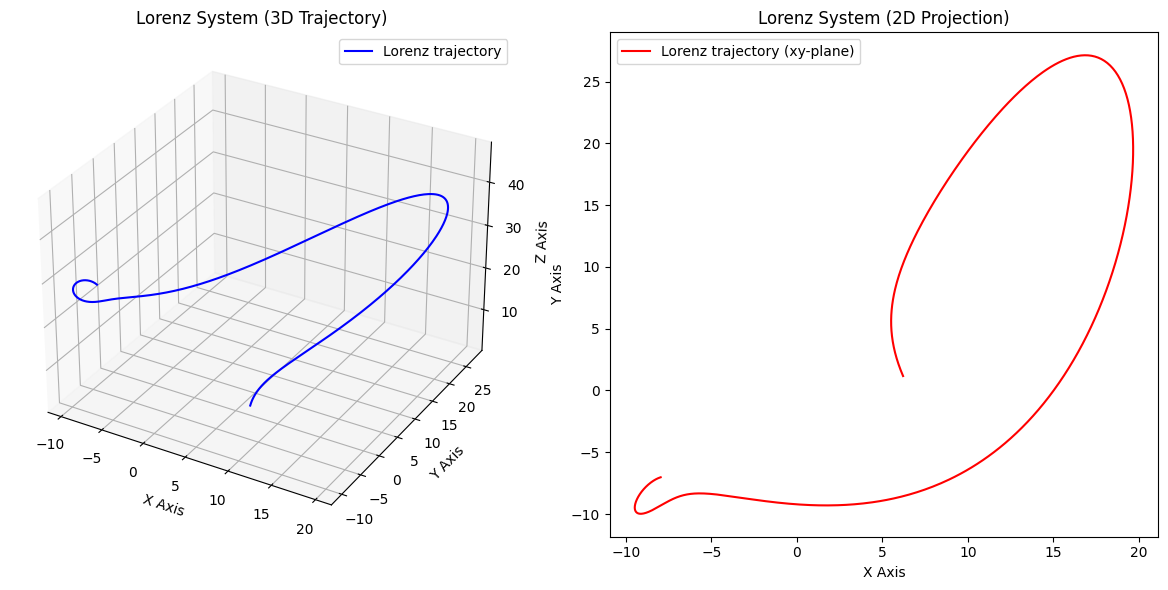

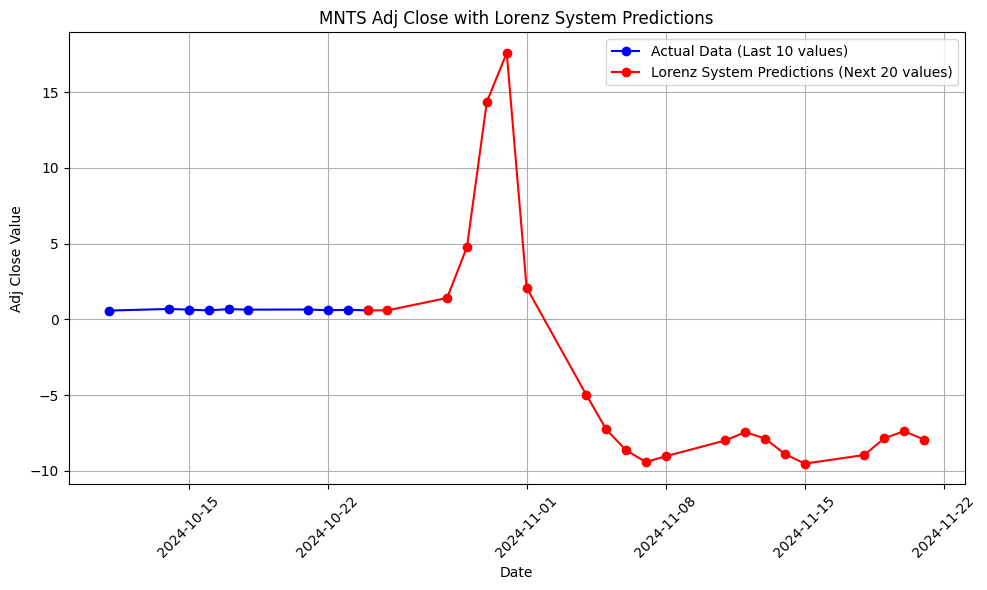

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.integrate import odeint

# Copy data
df = data

def lorenz_system(initial_state, dt, steps):
    sigma = 10.0
    rho = 28.0
    beta = 8.0 / 3.0

    state = np.array(initial_state)
    trajectory = np.zeros((steps, 3))

    for i in range(steps):
        dx = sigma * (state[1] - state[0])
        dy = state[0] * (rho - state[2]) - state[1]
        dz = state[0] * state[1] - beta * state[2]

        state[0] += dx * dt
        state[1] += dy * dt
        state[2] += dz * dt

        trajectory[i] = state

    return trajectory

# Simulate Lorenz system
initial_state = [np.mean(df['Volume']) / 1_000_000, 1.0, 1.05]
lorenz_trajectory = lorenz_system(initial_state, dt=0.001, steps=1000)
print(f"Lorenz trajectory: {lorenz_trajectory[:5]}")  # Show first 5 points

# Extract x, y, z coordinates
x = lorenz_trajectory[:, 0]
y = lorenz_trajectory[:, 1]
z = lorenz_trajectory[:, 2]

# Create a 3D plot
fig = plt.figure(figsize=(12, 6))

# 3D plot of Lorenz trajectory
ax_3d = fig.add_subplot(121, projection='3d')
ax_3d.plot(x, y, z, label='Lorenz trajectory', color='b')
ax_3d.set_xlabel('X Axis')
ax_3d.set_ylabel('Y Axis')
ax_3d.set_zlabel('Z Axis')
ax_3d.set_title('Lorenz System (3D Trajectory)')
ax_3d.legend()

# 2D plot of the same Lorenz trajectory projected onto the xy-plane
ax_2d = fig.add_subplot(122)
ax_2d.plot(x, y, label='Lorenz trajectory (xy-plane)', color='r')
ax_2d.set_xlabel('X Axis')
ax_2d.set_ylabel('Y Axis')
ax_2d.set_title('Lorenz System (2D Projection)')
ax_2d.legend()

# Show both plots
plt.tight_layout()
plt.show()

# 3rd chart

# Lorenz system parameters
sigma = 10
rho = 28
beta = 8 / 3

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    x0, y0 = last_10_values[-1], last_10_values[-2]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    x0, y0 = last_10_values[-1], last_10_values[-2]

# Set initial conditions and time points for prediction
z0 = 0.0  # Initial value for z
initial_conditions = [x0, y0, z0]
num_predictions = 20
time = np.linspace(0, 2, num_predictions)  # Time range for predictions

# Define the Lorenz system equations
def lorenz_system2(state, t):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# Integrate the Lorenz system
predicted_values = odeint(lorenz_system2, initial_conditions, time)

# Extract predicted x values for the time series
predicted_x_values = predicted_values[:, 0]  # We use x as the predicted series

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_x_values.tolist()

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Lorenz System Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Lorenz System Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Markov

**Markov Chain for Price**

In [ ]:
import pandas as pd
import numpy as np

# Copy data
df = data

def markov_chain_transition_state(data):
    """
    Generates the Markov Chain transition state matrix.

    Args:
        data: pandas DataFrame containing the price data.

    Returns:
        pandas DataFrame representing the transition state matrix and the predicted next state.
    """

    # Assuming 'Close' column contains the price data
    prices = data['Close'].values

    # Discretize prices into states (e.g., Low, Medium, High)
    low_threshold = data['Close'].quantile(0.33)
    high_threshold = data['Close'].quantile(0.66)
    states = np.where(prices < low_threshold, 'Low', np.where(prices > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Add "From/To" column for readability
    transition_matrix.index.name = "From/To"
    transition_matrix.reset_index(inplace=True)

    # Predict the next state based on the last observed state
    current_state = states[-1]  # Last observed state
    print(f"Current state: {current_state}")

    # Extract only the numeric columns (the state probabilities)
    state_probabilities = transition_matrix[transition_matrix['From/To'] == current_state].drop(columns=['From/To'])

    # Find the next state with the highest transition probability
    predicted_next_state = state_probabilities.idxmax(axis=1).values[0]

    return transition_matrix, predicted_next_state

# Assuming you have your data in a DataFrame called 'df'
transition_state, predicted_next_state = markov_chain_transition_state(df)
print(transition_state)
print(f"Next predicted state: {predicted_next_state}")

Current state: Medium
  From/To      High       Low    Medium
0    High  0.885714  0.000000  0.114286
1     Low  0.014706  0.867647  0.117647
2  Medium  0.089552  0.134328  0.776119
Next predicted state: Medium


**Markov Chain for Volumes**

In [ ]:
import pandas as pd
import numpy as np

# Copy data
df = data

def markov_chain_transition_state_volume(data):
    """
    Generates the Markov Chain transition state matrix and predicts the next state for Volumes.

    Args:
        data: pandas DataFrame containing the volume data.

    Returns:
        tuple: (pandas DataFrame representing the transition state matrix,
                 predicted next state)
    """

    # Convert 'Volume' column to numeric
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    # Assuming 'Volume' column contains the volume data
    volumes = data['Volume'].values

    # Discretize volumes into states (e.g., Low, Medium, High)
    low_threshold = data['Volume'].quantile(0.33)
    high_threshold = data['Volume'].quantile(0.66)
    states = np.where(volumes < low_threshold, 'Low', np.where(volumes > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Add "From/To" column for readability
    transition_matrix.index.name = "From/To"
    transition_matrix.reset_index(inplace=True)

    # Predict the next state based on the last observed state
    current_state = states[-1]  # Last observed state
    print(f"Current state: {current_state}")

    # Extract only the numeric columns (state probabilities)
    state_probabilities = transition_matrix[transition_matrix['From/To'] == current_state].drop(columns=['From/To'])

    # Find the next state with the highest transition probability
    predicted_next_state = state_probabilities.idxmax(axis=1).values[0]

    return transition_matrix, predicted_next_state

# Assuming you have your data in a DataFrame called 'df'
transition_state_volume, predicted_next_state_volume = markov_chain_transition_state_volume(df)
print(transition_state_volume)
print(f"Next predicted state for Volume: {predicted_next_state_volume}")

Current state: High
  From/To      High       Low    Medium
0    High  0.768116  0.000000  0.231884
1     Low  0.058824  0.720588  0.220588
2  Medium  0.191176  0.279412  0.529412
Next predicted state for Volume: High


Predicted next 10 volumes: [666187, 704358, 871270, 724510, 442294, 504947, 362587, 446679, 818647, 615178]


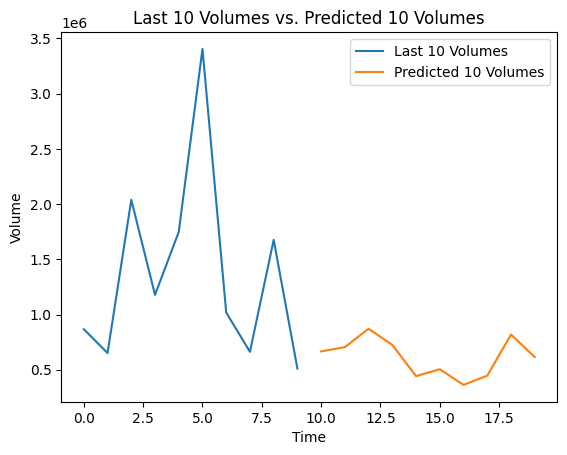

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Copy data
df = data

def predict_next_10_volumes(temp_data):
    """
    Predicts the next 10 volumes using a Markov Chain.

    Args:
        temp_data: List of volume temp_data.

    Returns:
        List of predicted next 10 volumes.
    """

    # Discretize volumes into states (e.g., Low, Medium, High)
    # Example discretization using quantiles:
    low_threshold = np.quantile(temp_data, 0.33)
    high_threshold = np.quantile(temp_data, 0.66)
    states = np.where(temp_data < low_threshold, 'Low', np.where(temp_data > high_threshold, 'High', 'Medium'))

    # Create transition state matrix
    unique_states = np.unique(states)
    transition_matrix = pd.DataFrame(0, index=unique_states, columns=unique_states)

    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix.loc[current_state, next_state] += 1

    # Normalize transition matrix to get probabilities
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

    # Predict next 10 volumes
    current_state = states[-1]  # Last observed state
    predicted_volumes = []
    for _ in range(10):
        predicted_next_state = transition_matrix[transition_matrix.index == current_state].idxmax(axis=1).values[0]
        # Map predicted state back to volume range
        if predicted_next_state == 'Low':
            predicted_volume = np.random.randint(int(temp_data.min()), int(low_threshold))
        elif predicted_next_state == 'High':
            predicted_volume = np.random.randint(int(high_threshold), int(temp_data.max()))
        else:  # Medium
            predicted_volume = np.random.randint(int(low_threshold), int(high_threshold))
        predicted_volumes.append(predicted_volume)
        current_state = predicted_next_state

    return predicted_volumes

temp_data = df['Volume']
predicted_volumes = predict_next_10_volumes(temp_data)
print("Predicted next 10 volumes:", predicted_volumes)

# Assuming you have the original temp_data in a variable called 'temp_data'
last_10_volumes = temp_data[-10:]

# Create x-axis values for plotting
x_values_last_10 = np.arange(len(last_10_volumes))
x_values_predicted = np.arange(len(last_10_volumes), len(last_10_volumes) + len(predicted_volumes))

# Plot the last 10 volumes
plt.plot(x_values_last_10, last_10_volumes, label='Last 10 Volumes')

# Plot the predicted 10 volumes
plt.plot(x_values_predicted, predicted_volumes, label='Predicted 10 Volumes')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('Last 10 Volumes vs. Predicted 10 Volumes')

# Add legend
plt.legend()

# Display the chart
plt.show()

# Mackey-Glass Equation - Chaotic Algorithm

Need to revise

                         Date   Open   High    Low  Close  Adj Close   Volume
0   2024-01-02 00:00:00+00:00  1.710  1.710  1.780  1.660      1.750   305700
1   2024-01-03 00:00:00+00:00  1.500  1.500  1.700  1.400      1.680   810000
2   2024-01-04 00:00:00+00:00  1.430  1.430  1.590  1.310      1.550   821800
3   2024-01-05 00:00:00+00:00  1.420  1.420  1.540  1.410      1.440   261200
4   2024-01-08 00:00:00+00:00  1.380  1.380  1.470  1.330      1.440   557600
..                        ...    ...    ...    ...    ...        ...      ...
208 2024-10-29 00:00:00+00:00  0.556  0.556  0.600  0.470      0.473  3404500
209 2024-10-30 00:00:00+00:00  0.520  0.520  0.551  0.510      0.540  1018100
210 2024-10-31 00:00:00+00:00  0.520  0.520  0.537  0.490      0.530   662500
211 2024-11-01 00:00:00+00:00  0.567  0.567  0.594  0.500      0.503  1676000
212 2024-11-04 00:00:00+00:00  0.565  0.565  0.585  0.546      0.565   510500

[213 rows x 7 columns]


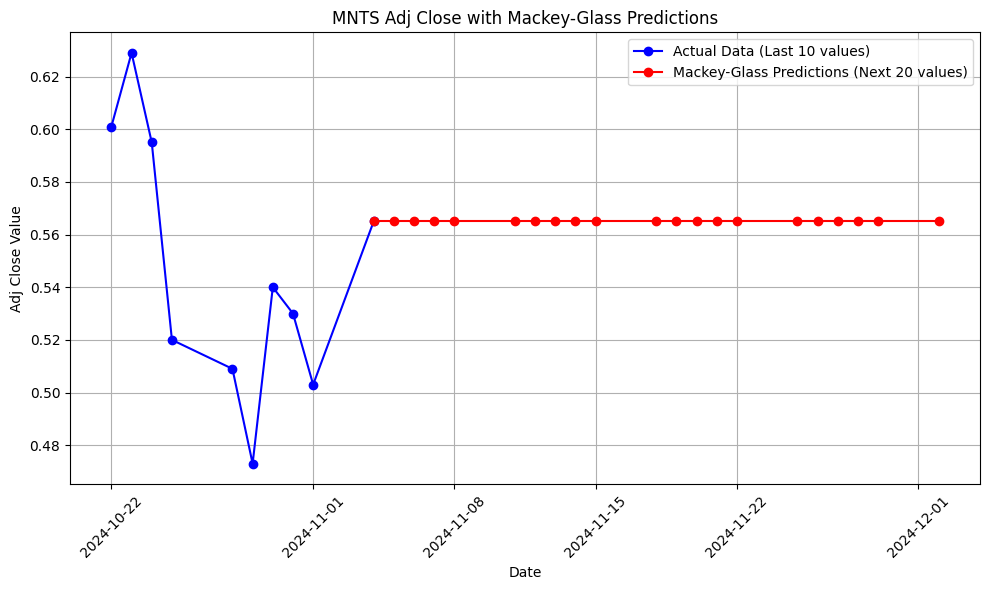

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# Copy data
df = data

print(df)

# Mackey-Glass equation parameters
a = 2
b = 1
n = 10
tau = 17  # Delay

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    initial_value = last_10_values[-1]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    initial_value = last_10_values[-1]

# Number of new values to predict with the Mackey-Glass equation
num_predictions = 20
time = np.linspace(0, 200, 1000)  # Time range for integration

# Extend initial history for the Mackey-Glass equation
history_length = tau + len(last_10_values)
initial_history = np.zeros(history_length)  # Initialize with zeros
initial_history[-len(last_10_values):] = last_10_values  # Fill with last known values

# Define the Mackey-Glass function
def mackey_glass(t, x):
    if t < tau:
        return [0]  # No feedback until t >= tau
    else:
        idx = int(t)  # Convert time to integer index
        if idx - tau >= 0 and idx < len(initial_history):
            return [(a * initial_history[idx - tau]) / (1 + initial_history[idx - tau] ** n) - b * x[0]]
        else:
            return [0]  # Return zero if out of bounds

# Use solve_ivp to integrate the Mackey-Glass equation
sol = solve_ivp(mackey_glass, [0, 200], [initial_value], t_eval=time)

# Get the predicted values
predicted_values = sol.y[0][-num_predictions:]  # Take the last 20 predicted values

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values.tolist()

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Mackey-Glass Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Mackey-Glass Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Pearson

**Pearson Correlation Coefficient**

In [ ]:
# Copy data
df = data

df[['Close', 'Volume']].corr()
corelation = df['Close'].corr(df['Volume'])
print(f"Pearson Correlation Coefficient: {corelation}")

def print_pearson_legend():
    print("### Pearson Correlation Interpretation ###\n")
    print("The Pearson Correlation Coefficient (r) ranges between -1 and +1 and describes the linear relationship between two variables.")
    print("\nInterpretation of the Pearson Coefficient:")
    print("  - **r = +1**: Perfect positive linear relationship (as one variable increases, the other increases).")
    print("  - **r = -1**: Perfect negative linear relationship (as one variable increases, the other decreases).")
    print("  - **r = 0**: No linear relationship between the variables.")
    print("\nRange Interpretation:")
    print("  - **0.7 ≤ |r| ≤ 1**: Strong linear relationship.")
    print("  - **0.3 ≤ |r| < 0.7**: Moderate linear relationship.")
    print("  - **0 ≤ |r| < 0.3**: Weak linear relationship.")
    print("\nNote: Pearson correlation only captures linear relationships. Nonlinear correlations may exist even if r is close to 0.\n")

# Example of calling the legend
print_pearson_legend()


Pearson Correlation Coefficient: 0.4058513721991079
### Pearson Correlation Interpretation ###

The Pearson Correlation Coefficient (r) ranges between -1 and +1 and describes the linear relationship between two variables.

Interpretation of the Pearson Coefficient:
  - **r = +1**: Perfect positive linear relationship (as one variable increases, the other increases).
  - **r = -1**: Perfect negative linear relationship (as one variable increases, the other decreases).
  - **r = 0**: No linear relationship between the variables.

Range Interpretation:
  - **0.7 ≤ |r| ≤ 1**: Strong linear relationship.
  - **0.3 ≤ |r| < 0.7**: Moderate linear relationship.
  - **0 ≤ |r| < 0.3**: Weak linear relationship.

Note: Pearson correlation only captures linear relationships. Nonlinear correlations may exist even if r is close to 0.



# Random Forest

Mean Squared Error: 3717413120036.357
R-squared: 0.5692017253635178


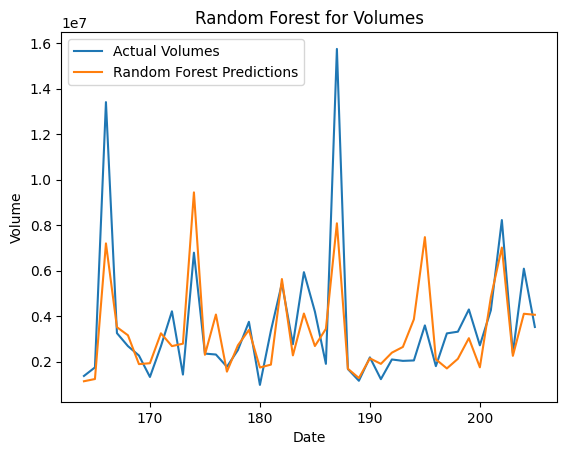

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Copy data
df = data

# Assuming your DataFrame is named 'df' and the volume column is 'Volume'

# Prepare data
X = np.arange(len(df)).reshape(-1, 1)  # Feature matrix (time steps)
y = df['Volume']  # Target variable (volume)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)  # Adjust parameters as needed
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared (coefficient of determination)
r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")

# Plot the results
plt.plot(df.index[-len(y_test):], y_test, label='Actual Volumes')
plt.plot(df.index[-len(y_test):], predictions, label='Random Forest Predictions')
plt.legend()
plt.title('Random Forest for Volumes')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# Rössler Attractor - Chaotic Algorithm

Need to revise

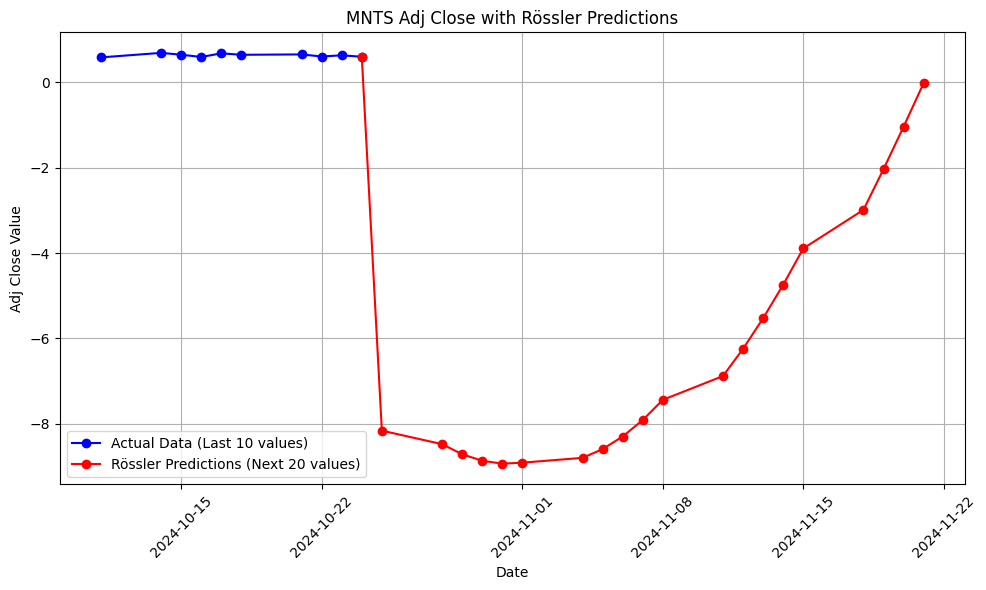

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

# Copy data
df = data

# Rössler attractor parameters
a = 0.2
b = 0.2
c = 5.7

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    initial_value = last_10_values[-1]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    initial_value = last_10_values[-1]

# Number of new values to predict with the Rössler attractor
num_predictions = 20

# Time span for integration
t_span = (0, 100)
time_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time range for integration

# Define the Rössler attractor equations
def rossler(t, state):
    x, y, z = state
    dxdt = -y - z
    dydt = x + a * y
    dzdt = b + z * (x - c)
    return [dxdt, dydt, dzdt]

# Use solve_ivp to integrate the Rössler attractor equations
initial_state = [initial_value, 0.0, 0.0]  # Assuming y and z start at 0
sol = solve_ivp(rossler, t_span, initial_state, t_eval=time_eval)

# Extract the predicted values (using x values for demonstration)
predicted_values = sol.y[0][-num_predictions:]  # Take the last 20 predicted x values

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values.tolist()

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Rössler Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Rössler Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Standard Map (Chirikov-Taylor Map) - Chaotic Algorithm

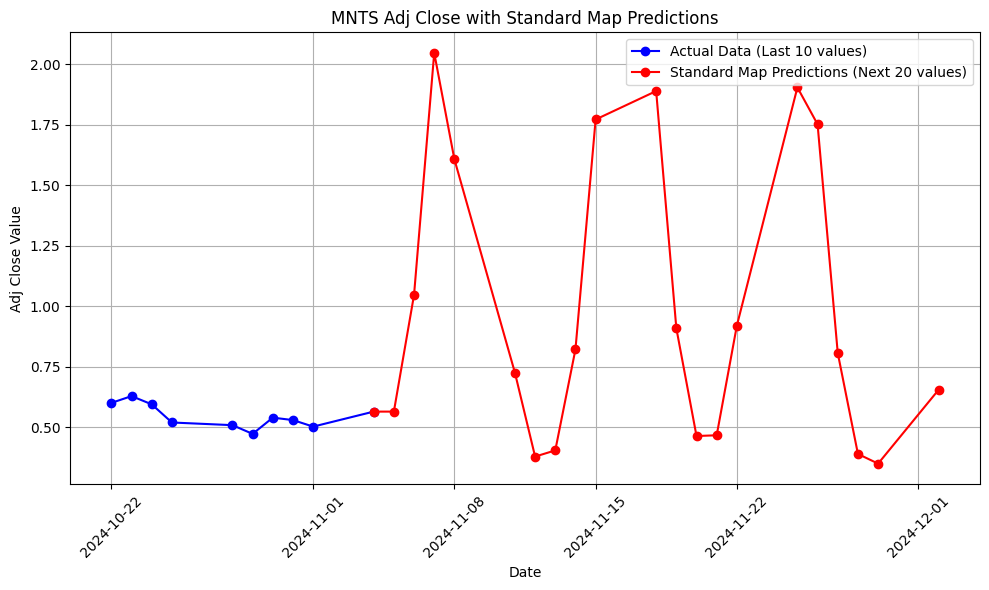

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Copy data
df = data

# Standard Map parameters
K = 1.0  # Nonlinearity parameter

# Check if df has at least 10 entries for the starting points
if len(df) >= 10:
    # Extract the last 10 `Adj Close` values as the basis for the time series
    last_10_values = df['Adj Close'].iloc[-10:].tolist()
    x, y = last_10_values[-1], last_10_values[-2]
else:
    print("DataFrame does not contain enough data points.")
    last_10_values = [1.0] * 10  # Fallback values if not enough data
    x, y = last_10_values[-1], last_10_values[-2]

# Number of new values to predict with the Standard Map
num_predictions = 20

# Arrays to store new predicted values
predicted_values = [x]  # Start with the last known value

# Generate the next 20 points using the Standard Map
for _ in range(num_predictions - 1):
    # Calculate the next values
    x_next = x + K * np.sin(y)
    y_next = y + x_next

    # Append the new prediction
    predicted_values.append(x_next)

    # Update x and y for the next iteration
    x, y = x_next, y_next

# Combine last 10 actual values with the 20 predictions
full_series = last_10_values + predicted_values

# Generate corresponding dates for the time series plot
# Assuming `Date` column exists in `df`
dates = pd.to_datetime(df['Date'].iloc[-10:].tolist())  # Last 10 dates from df
future_dates = pd.date_range(dates[-1] + pd.Timedelta(days=1), periods=num_predictions, freq='B')  # Business days for predictions
all_dates = dates.tolist() + future_dates.tolist()

# Plot the time series chart
plt.figure(figsize=(10, 6))
plt.plot(all_dates[:10], full_series[:10], 'bo-', label="Actual Data (Last 10 values)")
plt.plot(all_dates[9:], full_series[9:], 'ro-', label="Standard Map Predictions (Next 20 values)")
plt.xlabel("Date")
plt.ylabel("Adj Close Value")
plt.title(f"{ticker} Adj Close with Standard Map Predictions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Quantum Neural Network for Time Series Prediction

Not working


In [ ]:
!pip install pennylane pennylane-qiskit torch numpy matplotlib

INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 710.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 82.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.3 

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Set up the quantum device
n_qubits = 4  # Number of qubits to use in the quantum circuit
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum layer definition
def quantum_layer(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the QNN model
class QNN(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QNN, self).__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        # Initialize random quantum weights
        self.q_weights = torch.nn.Parameter(torch.randn(n_layers, n_qubits, 3))
        # Classical layers
        self.fc1 = nn.Linear(n_qubits, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        q_out = []
        # Use quantum circuit for each input data point
        for xi in x:
            q_out.append(qml.execute([quantum_layer], dev, [xi.numpy(), self.q_weights])[0])
        q_out = torch.tensor(q_out)
        # Apply classical neural network layers
        x = torch.relu(self.fc1(q_out))
        return self.fc2(x)

# Generate a toy time series data
np.random.seed(0)
n_points = 100
time_series = np.sin(np.linspace(0, 10 * np.pi, n_points)) + 0.1 * np.random.randn(n_points)

# Prepare the data for training
window_size = 10
X = []
y = []
for i in range(len(time_series) - window_size):
    X.append(time_series[i:i + window_size])
    y.append(time_series[i + window_size])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Initialize the QNN model
qnn_model = QNN(n_qubits, n_layers=3)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(qnn_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Train the QNN model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = qnn_model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

# Forecast the next 10 values
with torch.no_grad():
    future_X = X[-1].unsqueeze(0)  # Take the last known window
    future_preds = []
    for _ in range(10):
        future_y = qnn_model(future_X)
        future_preds.append(future_y.item())
        # Slide the window
        future_X = torch.cat([future_X[:, 1:], future_y.unsqueeze(1)], dim=1)

# Plot the results
plt.plot(range(len(time_series)), time_series, label='Actual Data')
plt.plot(range(len(time_series), len(time_series) + 10), future_preds, label='Predicted Data')
plt.legend()
plt.show()

TypeError: len() of unsized object

[*********************100%***********************]  1 of 1 completed
<ipython-input-3-b05e8d83d20d>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for i in range(int((max_val - min_val) / epsilon) + 1):


Box-Counting Dimension: 0.7243427625766775


<ipython-input-3-b05e8d83d20d>:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  for epsilon in epsilons for i in range(int((max(time_series_data) - min(time_series_data)) / epsilon) + 1)])
<ipython-input-3-b05e8d83d20d>:51: RuntimeWarning: divide by zero encountered in log
  log_N = np.log([np.sum((time_series_data >= min(time_series_data) + i * epsilon) &


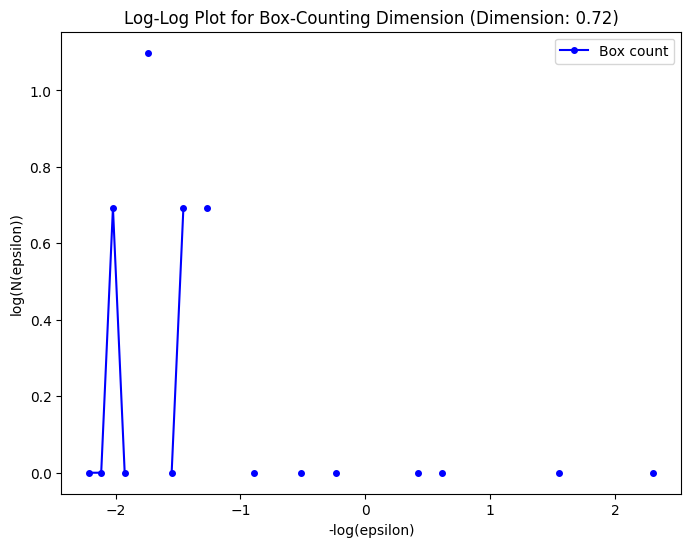

In [ ]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def box_counting_dimension(data, epsilons):
    """
    Calculate the box-counting dimension for a given time series.
    Parameters:
    - data: The 1D time series data.
    - epsilons: A list of box sizes (scales) to test.
    """
    N = []  # Stores the number of boxes required for each epsilon
    for epsilon in epsilons:
        count = 0
        min_val = min(data)
        max_val = max(data)

        # Define the grid of boxes by moving across intervals of size epsilon
        for i in range(int((max_val - min_val) / epsilon) + 1):
            # Check if there are any data points in the current box interval
            if any((data >= min_val + i * epsilon) & (data < min_val + (i + 1) * epsilon)):
                count += 1
        N.append(count)

    # Convert N and epsilon to logarithmic values for fitting
    log_eps = -np.log(epsilons)
    log_N = np.log(N)

    # Calculate the slope of the line, which is the fractal dimension
    coeffs = np.polyfit(log_eps, log_N, 1)
    return coeffs[0]

# Load a sample time series data for Apple Inc.
ticker = "AAPL"
start_date = "2024-01-01"
end_date = "2024-10-23"
df = yf.download(ticker, start=start_date, end=end_date)

# Use the closing prices for fractal analysis
time_series_data = df['Close'].dropna().values

# Define a range of box sizes (scales) for box-counting
epsilons = np.logspace(-1, 1, num=50)

# Calculate the box-counting dimension
dimension = box_counting_dimension(time_series_data, epsilons)
print("Box-Counting Dimension:", dimension)

# Log-log plot for visual verification
log_eps = -np.log(epsilons)
log_N = np.log([np.sum((time_series_data >= min(time_series_data) + i * epsilon) &
                       (time_series_data < min(time_series_data) + (i + 1) * epsilon))
                for epsilon in epsilons for i in range(int((max(time_series_data) - min(time_series_data)) / epsilon) + 1)])

plt.figure(figsize=(8, 6))
plt.plot(log_eps, log_N[:len(log_eps)], 'bo-', markersize=4, label='Box count')
plt.xlabel('-log(epsilon)')
plt.ylabel('log(N(epsilon))')
plt.title(f'Log-Log Plot for Box-Counting Dimension (Dimension: {dimension:.2f})')
plt.legend()
plt.show()